In [17]:
import os
import cv2
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from extract_features import extract_features 

In [18]:
csv_path = "features_train_banana_aug_balanced.csv"
df = pd.read_csv(csv_path)

print(f"Dataset shape: {df.shape}")
print("Class distribution:\n", df['label'].value_counts())

Dataset shape: (2861, 61)
Class distribution:
 label
None-leaf        1365
Diseased leaf     748
Healthy Leaf      748
Name: count, dtype: int64


In [19]:
df.head()

path          label  \
0  dataset/train_banana_aug\Diseased leaf\Banana ...  Diseased leaf   
1  dataset/train_banana_aug\Diseased leaf\Banana ...  Diseased leaf   
2  dataset/train_banana_aug\Diseased leaf\Banana ...  Diseased leaf   
3  dataset/train_banana_aug\Diseased leaf\Banana ...  Diseased leaf   
4  dataset/train_banana_aug\Diseased leaf\Banana ...  Diseased leaf   

      h_mean     h_std      s_mean      s_std      v_mean      v_std  \
0  32.662787  5.421608  174.621018  31.536488  141.637047  49.563890   
1  45.561595  5.288004  224.260542  30.552424  124.343622  21.467653   
2  44.520979  6.153641  168.185548  28.622999  107.479098  23.373493   
3  45.275449  6.564462  229.084951  36.635753   63.788033  19.688350   
4  44.494078  6.462468  220.107748  38.158202   89.640577  25.751976   

       l_mean      l_std  ...  lbp_15  lbp_16    lbp_17  hog_mean   hog_std  \
0  139.696907  48.546653  ...     0.0     0.0  0.113100  0.179853  0.274160   
1  118.975693  20.844470  ...     0.0     0.0  0.286505  0.170371  0.082051   
2  105.346392  23.379173  ...     0.0     0.0  0.327304  0.063115  0.110336   
3   60.097107  21.147074  ...     0.0     0.0  0.311384  0.111423  0.062541   
4   86.265017  26.198082  ...     0.0     0.0  0.307266  0.115007  0.101085   

   edge_density     area    perimeter  circularity  aspect_ratio  
0           0.0   5976.5   507.036577     0.292131      0.647482  
1           0.0  64256.0  1122.852812     0.640439      1.000000  
2           0.0  65025.0  1020.000000     0.785398      1.000000  
3           0.0  59921.0   971.622364     0.797616      1.000000  
4           0.0  58971.0   959.078208     0.805639      1.000000  

[5 rows x 61 columns]

In [20]:
X = df.drop(['path','label'], axis=1)
y = df['label']

le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = le.classes_

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

print(X_scaled)
print(y_encoded)

[[0.32470402 0.09547063 0.69115151 ... 0.13174657 0.34241832 0.08671634]
 [0.45293235 0.09311795 0.88762518 ... 0.29175806 0.75068316 0.13392858]
 [0.44258749 0.10836121 0.66567987 ... 0.26503315 0.92059511 0.13392858]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.26340412 0.04868609 0.25545641 ... 0.04479818 0.57357336 0.14968488]
 [0.74105411 0.79552205 0.41157934 ... 0.09795887 0.17374195 0.09271978]]
[0 0 0 ... 2 2 2]


In [21]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

knn = KNeighborsClassifier(n_neighbors=11, weights='distance', p=1)
knn.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=11, p=1, weights='distance')

In [22]:
with open("knn_features_model.pkl", "wb") as f:
    pickle.dump({
        "knn": knn,
        "scaler": scaler,
        "label_encoder": le,
        "feature_names": list(X.columns)
    }, f)

print(f"Training Accuracy: {accuracy_score(y_train, knn.predict(X_train)):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, knn.predict(X_test)):.4f}")

print("\nClassification Report (Test):")
print(classification_report(y_test, knn.predict(X_test), target_names=class_names))

Training Accuracy: 0.9991
Test Accuracy: 0.9127

Classification Report (Test):
               precision    recall  f1-score   support

Diseased leaf       0.82      0.92      0.87       150
 Healthy Leaf       0.91      0.95      0.93       150
    None-leaf       0.98      0.89      0.93       273

     accuracy                           0.91       573
    macro avg       0.90      0.92      0.91       573
 weighted avg       0.92      0.91      0.91       573



In [23]:
with open("knn_features_model.pkl", "rb") as f:
    model_data = pickle.load(f)



knn = model_data['knn']
scaler = model_data['scaler']
label_encoder = model_data['label_encoder']

test_dir = "dataset/test_data" #test data folder path ============not included in training model
y_true, y_pred, y_conf, image_paths = [], [], [], []

# Map folder names to training labels
label_map = {
    "Diseased_leaf": "Diseased leaf",
    "Healthy_leaf": "Healthy Leaf",
    "Non_leaf": "None-leaf"
}

# Loop over test images
for label in os.listdir(test_dir):
    class_folder = os.path.join(test_dir, label)
    if not os.path.isdir(class_folder):
        continue

    for f in os.listdir(class_folder):
        img_path = os.path.join(class_folder, f)
        try:
            feats = np.array(extract_features(img_path)).reshape(1, -1)
            feats_df = pd.DataFrame(feats, columns=model_data["feature_names"])  # keep names
            feats_scaled = scaler.transform(feats_df)

            pred_encoded = knn.predict(feats_scaled)
            pred_label = label_encoder.inverse_transform(pred_encoded)[0]
            proba = knn.predict_proba(feats_scaled).max() if hasattr(knn, "predict_proba") else 1.0

            true_label = label_map.get(label, label)
            if true_label not in label_encoder.classes_:
                continue

            y_true.append(true_label)
            y_pred.append(pred_label)
            y_conf.append(proba)
            image_paths.append(img_path)

        except Exception as e:
            print("❌ Error:", img_path, e)

# =========================================================
# 📌 4. Reports & Plots
# =========================================================
print("\n📊 Classification Report (Folder Test Data):")
print(classification_report(y_true, y_pred, labels=label_encoder.classes_))



📊 Classification Report (Folder Test Data):
               precision    recall  f1-score   support

Diseased leaf       0.92      0.92      0.92        13
 Healthy Leaf       0.87      1.00      0.93        13
    None-leaf       1.00      0.85      0.92        13

     accuracy                           0.92        39
    macro avg       0.93      0.92      0.92        39
 weighted avg       0.93      0.92      0.92        39



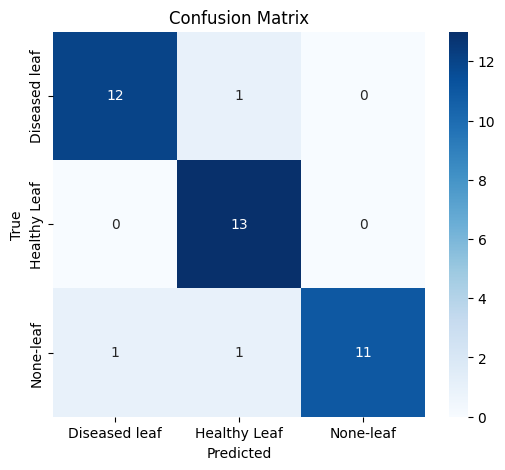

In [24]:
cm = confusion_matrix(y_true, y_pred, labels=label_encoder.classes_)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [25]:
report = classification_report(y_true, y_pred, output_dict=True, labels=label_encoder.classes_)
print("\n✅ Accuracy per class:")
for cls in label_encoder.classes_:
    print(f"{cls}: {report[cls]['recall']*100:.2f}%")


✅ Accuracy per class:
Diseased leaf: 92.31%
Healthy Leaf: 100.00%
None-leaf: 84.62%


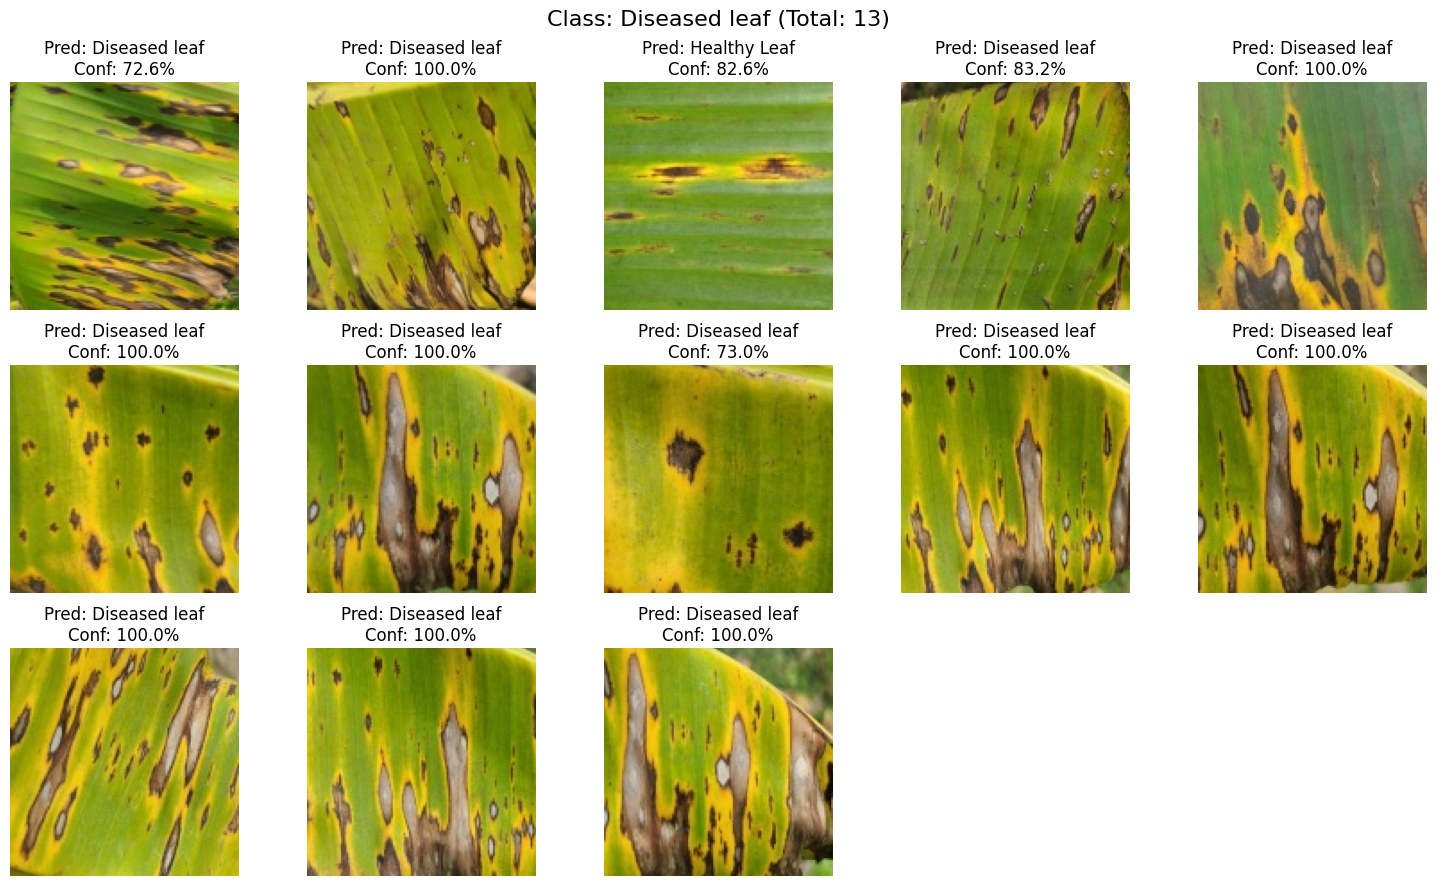

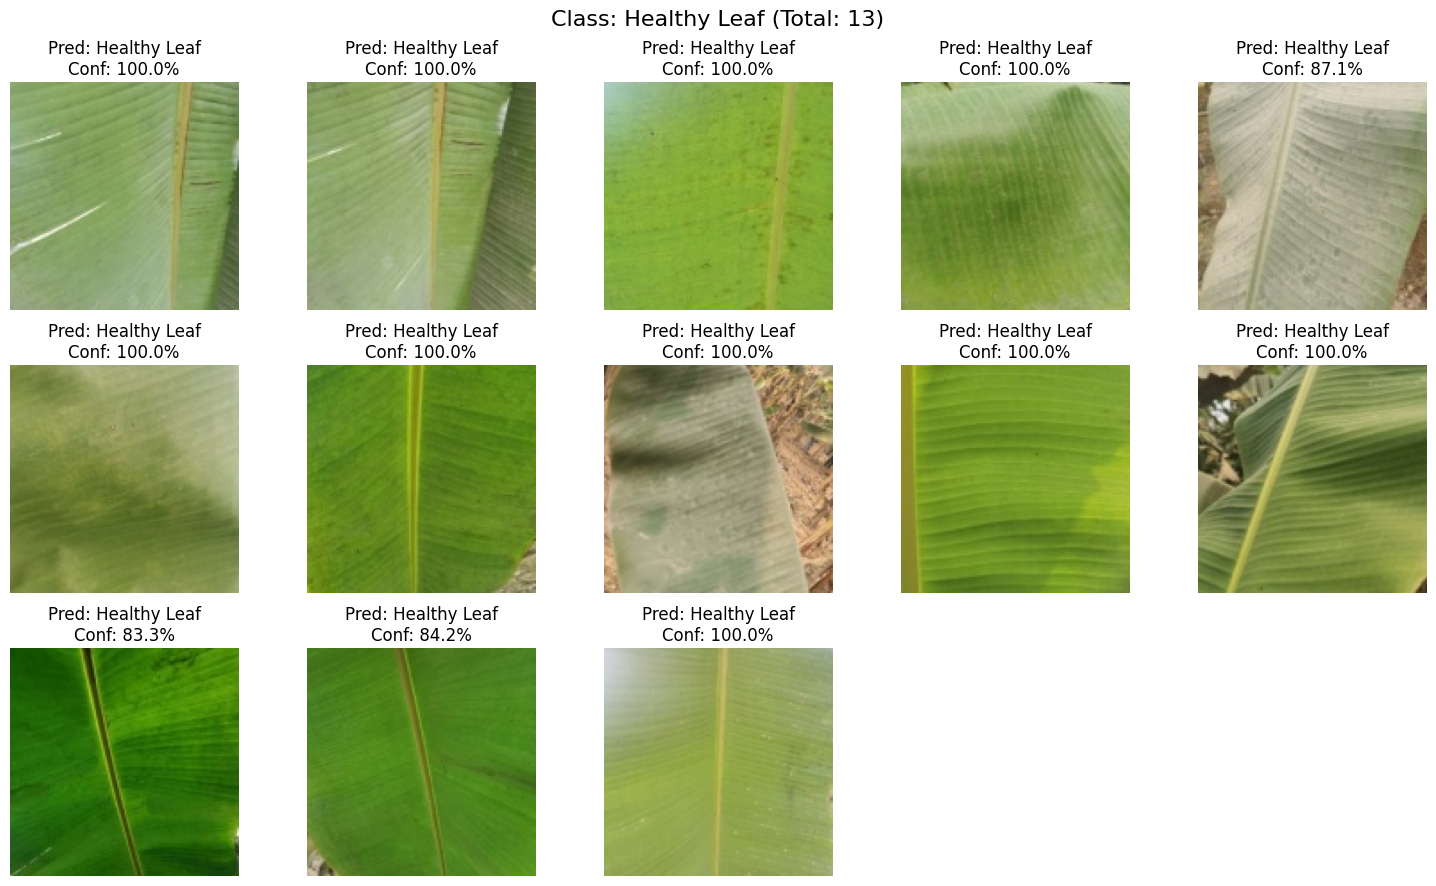

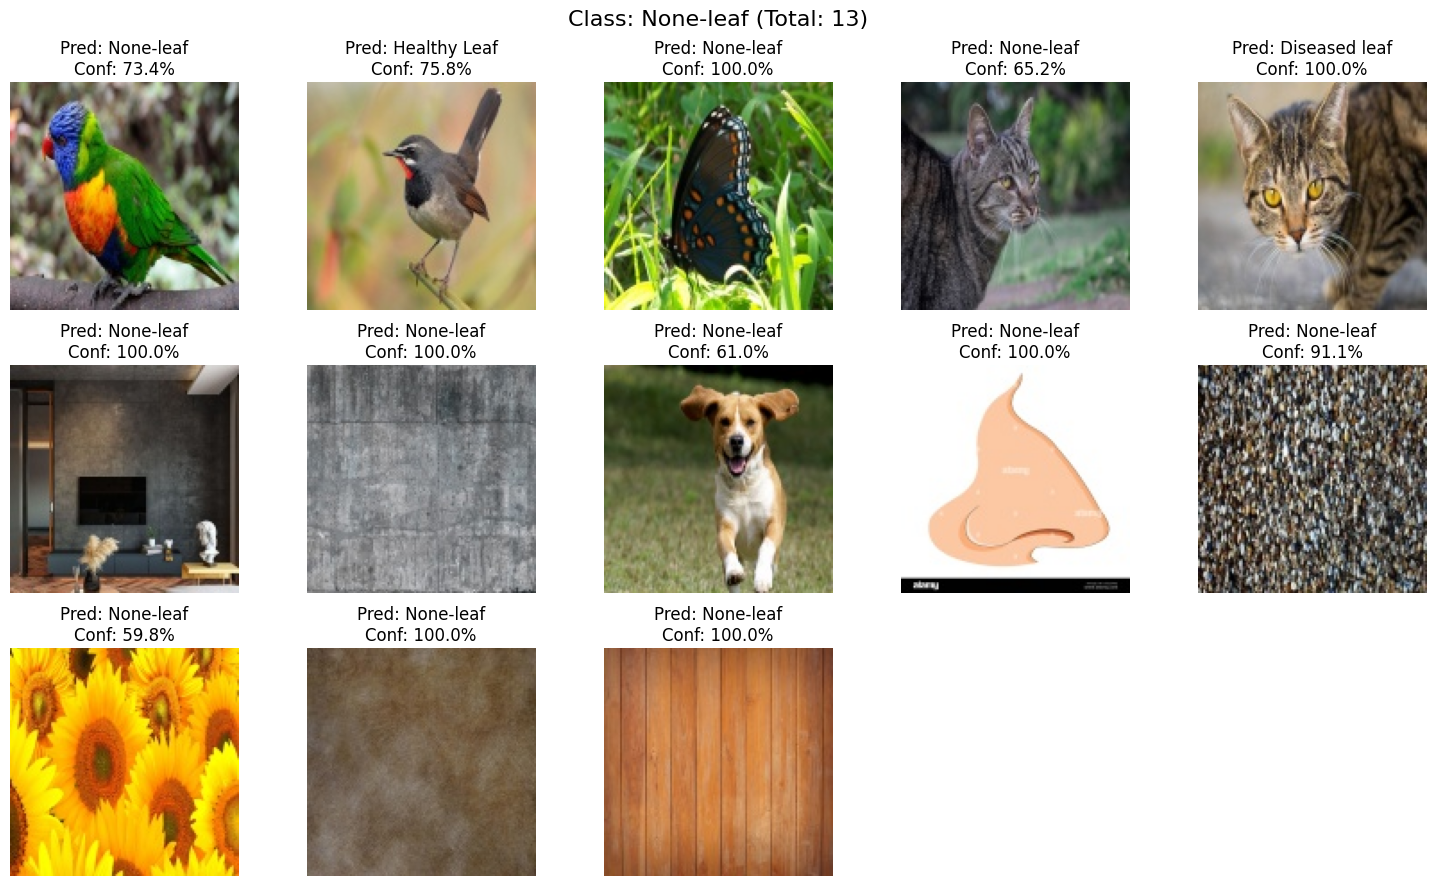

In [26]:
# Show sample images grouped by class
for cls in label_encoder.classes_:
    idxs = [i for i in range(len(image_paths)) if y_true[i] == cls]
    if not idxs:
        continue

    n_imgs = len(idxs)
    cols, rows = 5, int(np.ceil(n_imgs/5))
    plt.figure(figsize=(15, rows*3))
    for j, idx in enumerate(idxs):
        img = cv2.imread(image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(rows, cols, j+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Pred: {y_pred[idx]}\nConf: {y_conf[idx]*100:.1f}%")

    plt.suptitle(f"Class: {cls} (Total: {n_imgs})", fontsize=16)
    plt.tight_layout()
    plt.show()

d:\Users\daseb\OneDrive\Desktop\Project\Banana_leaf\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


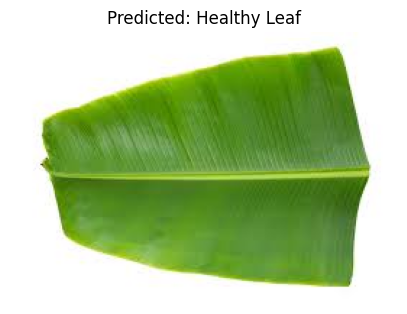

Diseased leaf: 8.48%
Healthy Leaf: 91.52%
None-leaf: 0.00%


In [27]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# --- Load new image ---
img_path = "dataset/Google_img/bay.jpeg" #change image path here single imgs
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

feats = extract_features(img_path)
feats_scaled = scaler.transform([feats])  

# --- Predict ---
pred_encoded = knn.predict(feats_scaled)
pred_label = le.inverse_transform(pred_encoded)[0]

if hasattr(knn, "predict_proba"):
    probs = knn.predict_proba(feats_scaled)[0]
else:
    probs = np.zeros(len(le.classes_))
    probs[pred_encoded[0]] = 1.0 

# --- Show image ---
plt.figure(figsize=(5,5))
plt.imshow(img_rgb)
plt.axis('off')
plt.title(f"Predicted: {pred_label}")
plt.show()


for cls, p in zip(le.classes_, probs):
    print(f"{cls}: {p*100:.2f}%")
